In [1]:
import os
import config as c
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.datasets import fetch_california_housing
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go

from visualization.utils import plot_correlation_matrix, plot_scatterplot_matrix
from utils.metrics import NIC
from utils.dataset import *
from utils.metrics import NIC
from sklearn.metrics import mean_squared_error
from utils.model import Model, get_combine_predictions

init_notebook_mode(connected=True)

warnings.filterwarnings('ignore')
plt.rcParams ['figure.figsize'] = (13,8)
sns.set()
%config InlineBackend.figure_format = 'retina'

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [175]:
df_funnel, df_appl, df_aum, df_balance, df_client, df_com, df_deals, df_payments = get_dataset(True, True)

['feature_1_client_segment']


# Создание фич

In [176]:
df_appl.groupby('appl_prod_type_name').count()

,client_id,month_end_dt,appl_prod_group_name,appl_stts_name_dc,appl_sale_channel_name
appl_prod_type_name,,,,,
Credit cards,3558,3558,3558,2577,3536
Debit cards,4749,4749,4749,3364,4748
Mortgage,34,34,34,10,0
PILS,3689,3689,3689,2616,3682


In [177]:
appl_credit_cards = df_appl[df_appl.appl_prod_type_name=='Credit cards'].groupby('client_id').count()[['month_end_dt']]
appl_credit_cards = appl_credit_cards.rename(columns={'month_end_dt': 'appl_credit_cards'})
df_funnel = pd.concat([df_funnel.set_index('client_id'), appl_credit_cards], axis=1).reset_index()

In [178]:
coms = df_com.groupby('client_id').sum()[['agr_flg', 'otkaz', 'count_comm']]
df_funnel = pd.concat([df_funnel.set_index('client_id'), coms], axis=1).reset_index()

In [179]:
df_funnel['otkaz_p'] = df_funnel.otkaz / df_funnel.count_comm
df_funnel['agr_flg_p'] = df_funnel.agr_flg / df_funnel.count_comm

In [182]:
df_funnel['agr_flg_p'] = df_funnel.agr_flg / (df_funnel.otkaz_p+1)

In [183]:
df_funnel.corr()

,client_id,sale_flg,sale_amount,contacts,feature_1,client_segment,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,region_cd,month_payments,feature_10div7,freq_client_segment,freq_feature_1,freq_feature_9,feature_1_client_segment,freq_feature_1_client_segment,gender,age,region,city,citizenship,education,job_type,ring_up_flg_sum,is_pensioner,appl_credit_cards,agr_flg,otkaz,count_comm,otkaz_p,agr_flg_p
client_id,1.000000,0.002857,0.024852,0.001679,-0.002944,-0.002263,0.006095,0.014837,0.002039,0.006921,0.009066,0.008815,0.008402,-0.003082,0.006325,-0.007083,0.012488,0.001479,-0.007176,0.002126,0.002878,0.002950,-0.007002,-0.008711,-0.007509,-0.007042,0.000983,0.007594,0.001585,-0.000071,-0.008722,-0.002036,0.006913,-0.004030,-0.007975,-0.014206,0.000804,-0.003889
sale_flg,0.002857,1.000000,NaN,0.026489,-0.038500,-0.301903,0.061878,0.023095,0.080969,0.124936,0.018460,0.158792,0.103732,-0.170401,0.146864,0.031092,0.018338,-0.123308,-0.164907,-0.025334,0.014339,-0.031458,-0.196077,-0.018222,-0.023022,-0.056472,-0.098920,-0.003017,0.243662,0.011273,0.126524,0.008870,0.030426,0.164141,0.114507,0.058411,0.034925,0.163617
sale_amount,0.024852,NaN,1.000000,-0.014242,-0.048497,-0.054515,0.153004,0.355598,0.443969,0.180681,0.369305,0.423668,0.325351,-0.153346,0.401972,0.170864,0.214024,-0.122544,-0.046127,-0.080837,-0.002301,-0.040862,-0.034348,0.002761,0.094231,-0.146293,-0.104871,NaN,-0.158688,-0.004128,0.047482,0.040463,0.030224,0.057329,0.036062,0.032119,0.005251,0.056972
contacts,0.001679,0.026489,-0.014242,1.000000,0.000061,-0.127788,0.056231,0.009877,0.043545,0.023176,0.020651,0.061132,0.043909,-0.044144,0.064574,0.025690,-0.022700,-0.023590,-0.123624,-0.028496,0.040943,0.009323,-0.101380,-0.015655,-0.023058,-0.035442,-0.017541,-0.003081,0.064325,0.003379,0.084453,0.005100,-0.018320,0.037422,0.067512,0.039152,0.011956,0.037006
feature_1,-0.002944,-0.038500,-0.048497,0.000061,1.000000,-0.021809,-0.076170,0.007475,0.022636,0.040125,-0.000189,0.004500,0.020164,0.364298,0.026079,0.000358,0.040027,0.240824,0.002284,-0.354115,-0.103247,-0.113630,0.000229,0.002177,-0.023785,-0.003665,0.003439,0.005381,0.005001,-0.006486,-0.027981,0.023980,0.003868,0.011948,-0.010297,-0.037766,0.008747,0.011688
client_segment,-0.002263,-0.301903,-0.054515,-0.127788,-0.021809,1.000000,-0.249073,-0.044008,-0.010310,-0.345321,0.062780,-0.256016,-0.224624,0.371675,-0.213657,-0.049899,-0.067893,0.250509,0.261177,0.268465,-0.240602,-0.020159,0.416872,0.054500,-0.013160,0.086111,0.040424,0.009547,-0.217820,0.008280,-0.189532,0.014419,-0.071203,-0.116297,-0.182628,-0.162760,-0.072417,-0.115305
feature_2,0.006095,0.061878,0.153004,0.056231,-0.076170,-0.249073,1.000000,0.181361,-0.032096,0.479146,0.002814,0.403771,0.426070,-0.492811,0.313081,0.058268,0.408856,-0.330261,0.005177,-0.456541,0.420864,0.073005,-0.100474,-0.080813,0.124906,-0.087676,-0.057365,-0.008818,0.054626,-0.008434,0.120538,0.001916,-0.009122,-0.002849,0.096763,0.137516,0.037249,-0.003123
feature_3,0.014837,0.023095,0.355598,0.009877,0.007475,-0.044008,0.181361,1.000000,0.522517,0.308595,0.594992,0.294424,0.295519,-0.014985,0.267812,0.033135,0.776815,-0.017120,-0.012745,-0.039030,-0.001815,-0.004930,-0.012631,0.050445,-0.015627,-0.023066,-0.041689,-0.001678,-0.040618,-0.007098,0.017627,0.037194,0.076360,0.019655,0.022324,-0.000407,0.028361,0.019339
feature_4,0.002039,0.080969,0.443969,0.043545,0.022636,-0.010310,-0.032096,0.522517,1.000000,0.035975,0.700480,0.158374,0.105085,0.107561,0.169582,0.034584,0.203548,0.050126,-0.037949,0.041249,-0.131337,-0.048205,0.006670,0.043331,-0.027014,-0.027156,-0.041988,-0.003163,-0.045718,-0.009673,0.019224,0.061685,0.118157,0.070812,0.028425,-0.044218,0.021494,0.070253
feature_5,0.006921,0.124936,0.180681,0.023176,0.040125,-0.345321,0.479146,0.308595,0.035975,1.000000,0.000463,0.351305,0.388214,-0.248254,0.273781,0.073736,0.889357,-0.175860,-0.034064,-0.262418,0.126504,-0.003336,-0.137034,0.025065,-0.002505,-0.115405,-0.0

In [122]:
df

,client_id,sale_flg,sale_amount,contacts,feature_1,client_segment,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,region_cd,month_payments,feature_10div7,freq_client_segment,freq_feature_1,freq_feature_9,feature_1_client_segment,freq_feature_1_client_segment,gender,age,region,city,citizenship,education,job_type,ring_up_flg_sum,is_pensioner,salary_cards_agrmnt_sum_rur_mean,salary_cards_agrmnt_sum_rur_sum,credit_cards_agrmnt_rate_active,credit_cards_agrmnt_sum_rur,sale_flg_predict
0,-9221941791080978530,0,NaN,1,9,13,1821184.0,79089.0,132280.0,0.0,166263.0,1349.512505,1596130.0,194,10.771533,16,NaN,0.026161,3865,2012,476,31472095,334,55138076,35,22,688,11175746,26418121,41838474,0.0,NaN,NaN,NaN,NaN,NaN,0.040927
1,-9220369594510368140,0,NaN,1,1,13,3642369.0,11288.0,6556.0,0.0,12464.0,713.244699,420428.0,119,9.331761,50,NaN,0.022193,3865,2491,1228,53829501,461,52748146,54,8,729,11175746,26418121,41838474,4.0,NaN,NaN,NaN,NaN,NaN,0.029480
2,-9220236243053692422,1,32920.9,2,1,3,3642369.0,24469.0,23073.0,16764.0,49060.0,1068.305200,436482.0,89,10.105407,36,15737.333333,0.021444,4139,2491,2488,4816232,351,52748146,39,52,953,11175746,26418121,41838474,NaN,0.0,0.0,0.0,NaN,NaN,0.294206
3,-9220233431709087652,0,NaN,1,6,1,1371274.0,77447.0,27857.0,61894.0,15563.0,1170.788196,1177470.0,119,10.322954,86,32787.000000,0.022194,2221,2388,1228,17089825,149,52748146,27,0,41,11175746,64282531,41838474,4.0,0.0,0.0,0.0,26.9,0.0,0.573013
4,-9219699286371310531,0,NaN,1,7,3,352826.0,5500.0,0.0,4244.0,0.0,515.648136,204534.0,89,8.614138,62,4629.636364,0.020715,4139,2675,2488,52921881,461,55138076,60,60,4166,11175746,26418121,41838474,4.0,0.0,0.0,0.0,NaN,NaN,0.017929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21493,9219024469308275500,0,NaN,1,4,3,6070615.0,10658.0,14642.0,12445.0,30515.0,730.068490,198936.0,74,9.274441,68,7467.200000,0.020002,4139,2516,739,40213991,537,52748146,49,48,714,11175746,26418121,41838474,NaN,0.0,0.0,0.0,NaN,NaN,0.151787
21494,9219416956046769492,0,NaN,1,7,14,536675.0,1871.0,13483.0,0.0,26355.0,297.709590,68178.0,99,7.539027,78,NaN,0.021200,4689,2675,1971,54579379,588,55138076,34,25,33,11175746,26418121,41838474,4.0,NaN,NaN,NaN,NaN,NaN,0.034206
21495,9219968212912398941,0,NaN,1,6,13,306824.0,8182.0,0.0,0.0,5370.0,554.231901,253862.0,149,8.894670,86,NaN,0.023739,3865,2388,1181,25522508,460,55138076,44,0,2,11175746,26418121,41838474,4.0,NaN,NaN,NaN,NaN,NaN,0.015714
21496,9220335314469087849,0,NaN,1,5,3,615909.0,18654.0,0.0,25541.0,0.0,784.576319,486293.0,89,9.453208,28,15792.523810,0.020710,4139,2637,2488,47928774,474,52748146,33,32,53,11175746,26418121,41838474,0.0,1.0,13507.0,27014.0,NaN,NaN,0.104286


In [120]:
df['sale_flg_predict'] = model_sale_flg.predict(x)

100%|██████████| 10/10 [00:00<00:00, 163.95it/s]


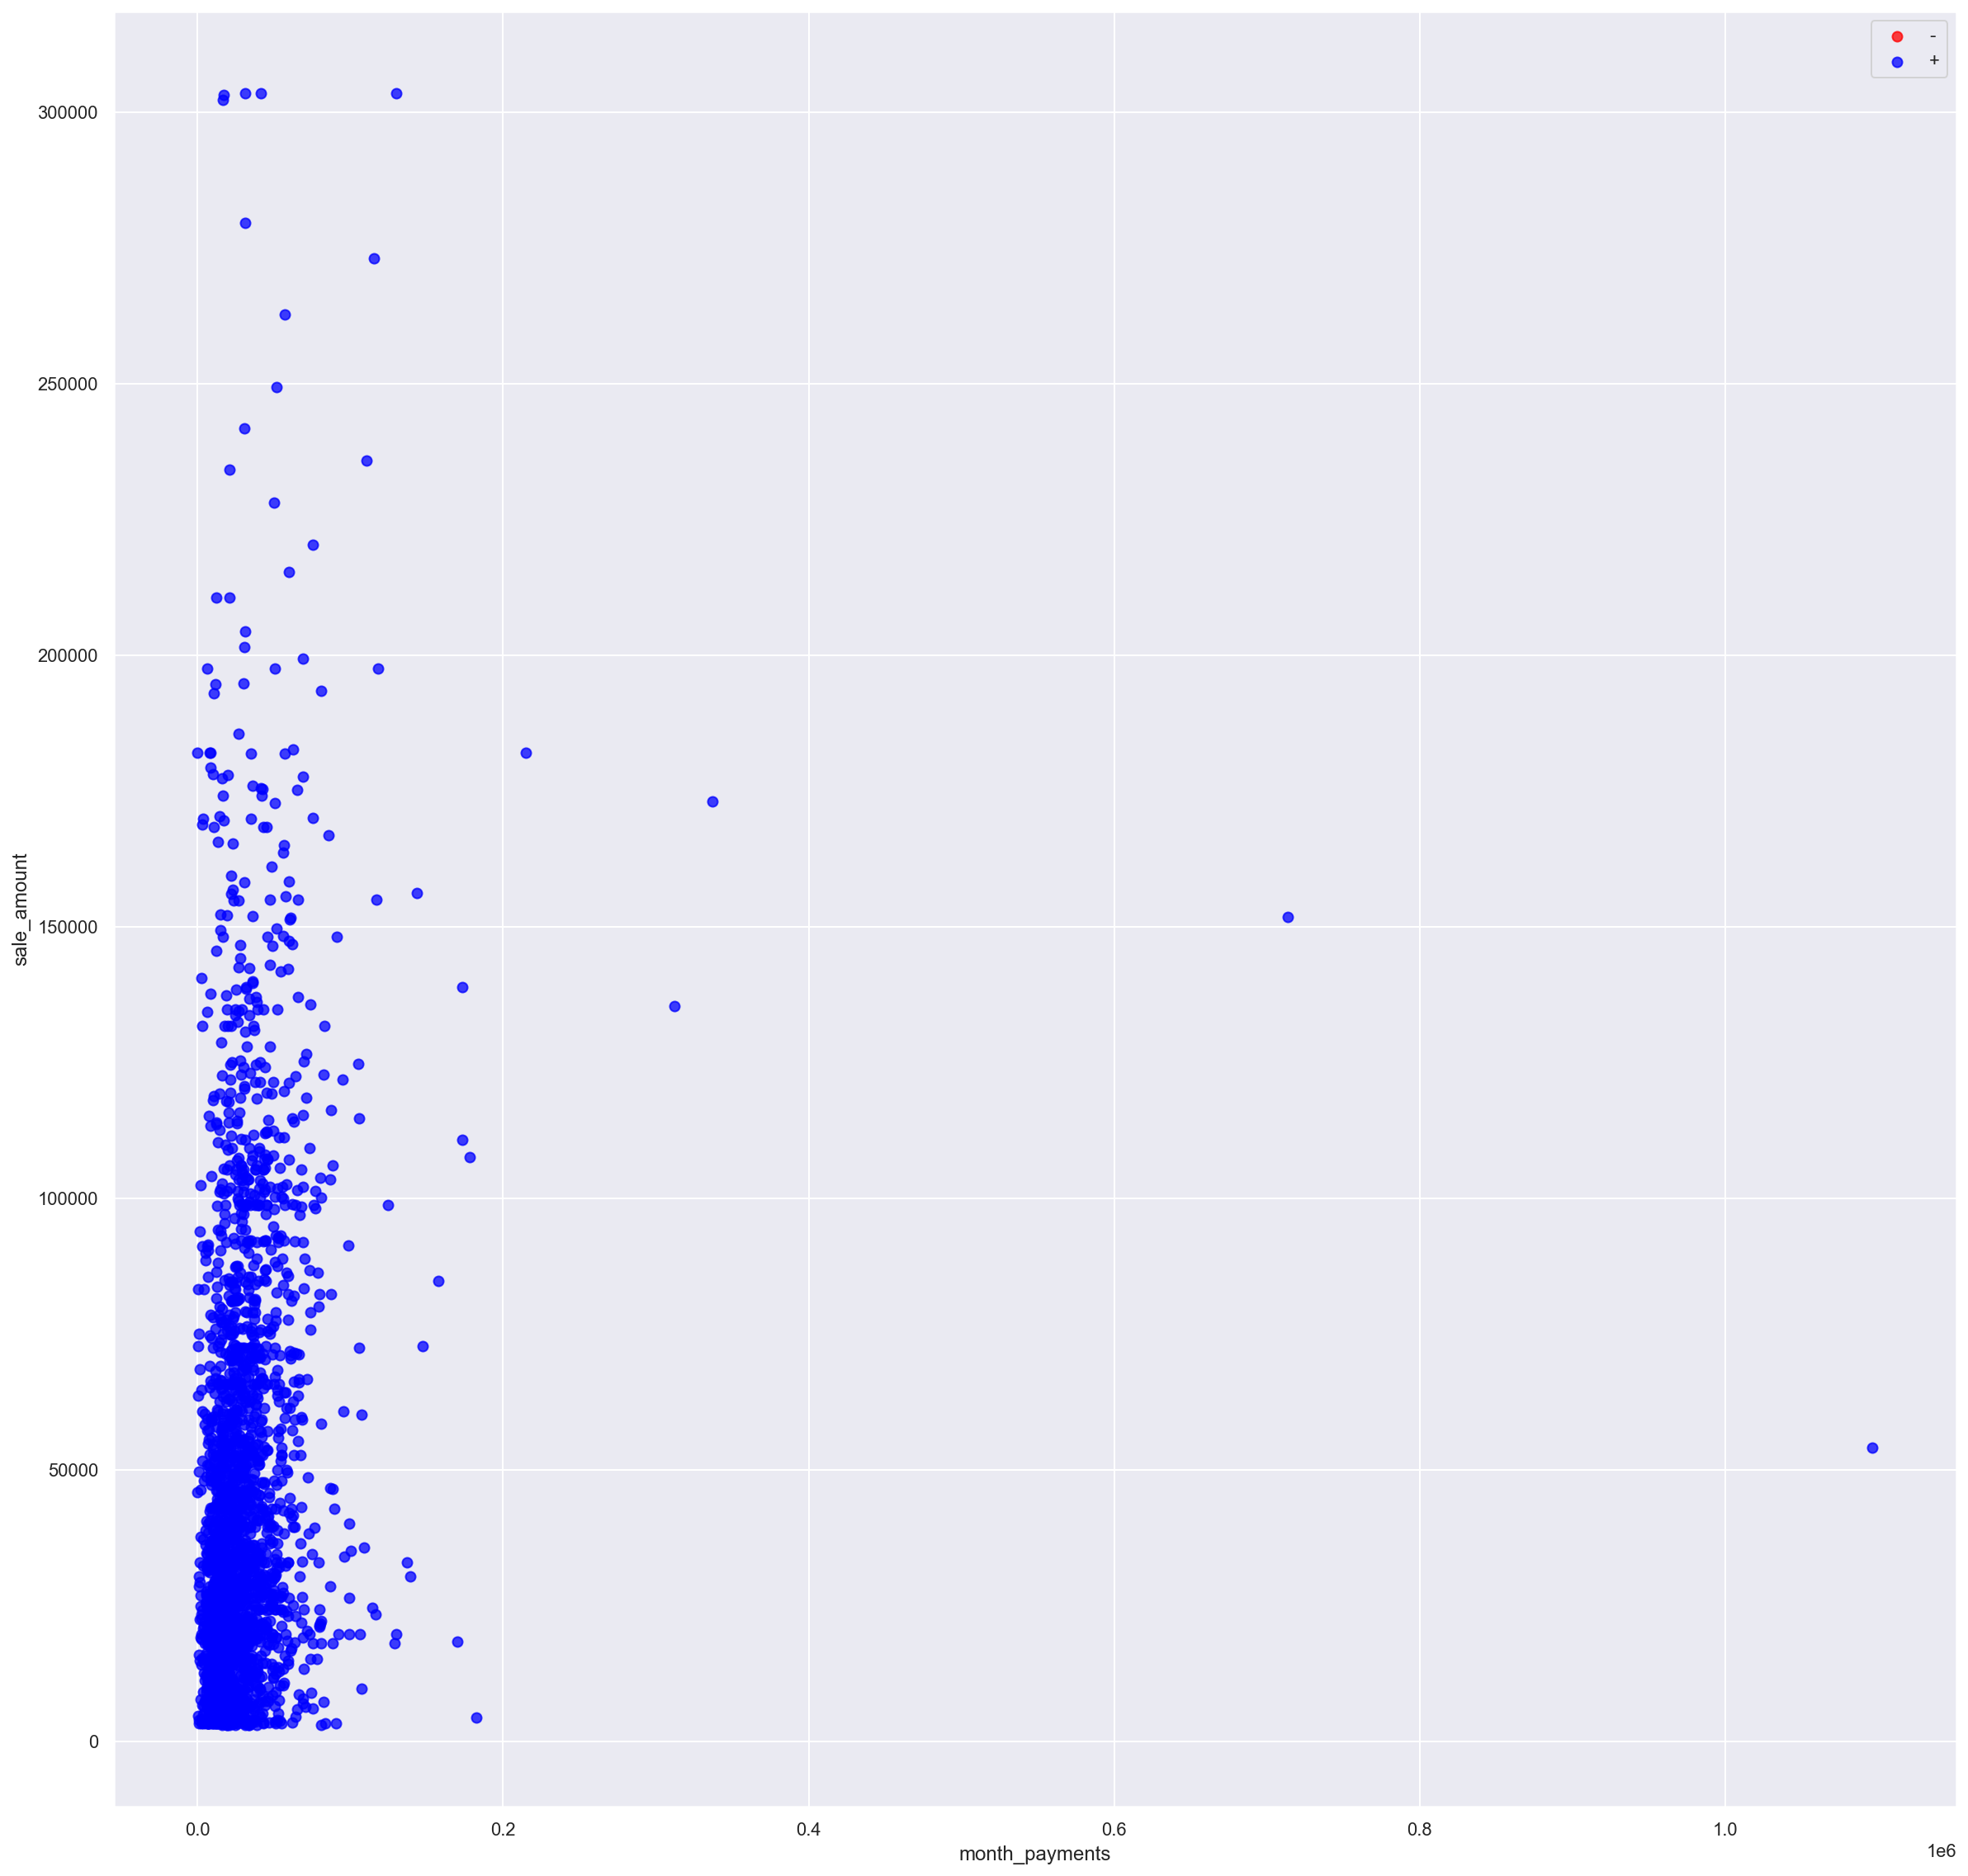

In [140]:
col1 = 'month_payments'
col2 = 'sale_amount'

plt.figure(figsize=(20, 20))

plt.scatter(df[col1][df['sale_flg'] == 0],
            df[col2][df['sale_flg'] == 0],
            alpha=0.75,
            color='red',
            label='-')

plt.scatter(df[col1][df['sale_flg'] == 1],
            df[col2][df['sale_flg'] == 1],
            alpha=0.75,
            color='blue',
            label='+')

plt.xlabel(col1)
plt.ylabel(col2)
plt.legend(loc='best');

In [184]:
df = df_funnel.copy()

x = df[df['sale_amount'].fillna(0) > 0].drop(columns=['client_id', 'sale_flg', 'sale_amount', 'contacts']).to_numpy()
y = df[df['sale_amount'].fillna(0) > 0]['sale_amount'].to_numpy().reshape(-1, 1)

model_sale_amount = Model('model_sale_amount')
model_sale_amount.fit(x, y)
print(mean_squared_error(y, model_sale_amount.predict(x)))


x = df.drop(columns=['client_id', 'sale_flg', 'sale_amount', 'contacts']).to_numpy()
y = df['sale_flg'].to_numpy().reshape(-1, 1)

model_sale_flg = Model('model_sale_flg')
model_sale_flg.fit(x, y)
print(mean_squared_error(y, model_sale_flg.predict(x)))

x = df.drop(columns=['client_id', 'sale_flg', 'sale_amount', 'contacts']).to_numpy()

target = get_combine_predictions(x, model_sale_flg, model_sale_amount)
print('NIC:', NIC(target, df['sale_amount'], df['contacts']))

10it [00:10,  1.04s/it]
100%|██████████| 10/10 [00:00<00:00, 294.13it/s]
0it [00:00, ?it/s]

Models score: -437.48067291698936
1073723674.7195885


10it [00:11,  1.18s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

Models score: -2585.0969569270987
0.09496403755954556


100%|██████████| 10/10 [00:00<00:00, 169.50it/s]

NIC: 4817.731886687134


In [18]:
df['target'] = target
df['sale_amount_predict'] = model_sale_amount.predict(x)

100%|██████████| 10/10 [00:00<00:00, 163.94it/s]


In [19]:
df

,client_id,sale_flg,sale_amount,contacts,feature_1,client_segment,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,region_cd,month_payments,feature_10div7,freq_client_segment,freq_feature_1,freq_feature_9,feature_1_client_segment,freq_feature_1_client_segment,gender,age,region,city,citizenship,education,job_type,ring_up_flg_sum,is_pensioner,target,sale_amount_predict
0,-9221941791080978530,0,NaN,1,9,13,1821184.0,79089.0,132280.0,0.0,166263.0,1349.512505,1596130.0,194,10.771533,16,NaN,0.026161,3865,2012,476,31472095,334,55138076,35,22,688,11175746,26418121,41838474,0.0,NaN,0,69898.560272
1,-9220369594510368140,0,NaN,1,1,13,3642369.0,11288.0,6556.0,0.0,12464.0,713.244699,420428.0,119,9.331761,50,NaN,0.022193,3865,2491,1228,53829501,461,52748146,54,8,729,11175746,26418121,41838474,4.0,NaN,0,22426.954622
2,-9220236243053692422,1,32920.9,2,1,3,3642369.0,24469.0,23073.0,16764.0,49060.0,1068.305200,436482.0,89,10.105407,36,15737.333333,0.021444,4139,2491,2488,4816232,351,52748146,39,52,953,11175746,26418121,41838474,NaN,0.0,1,31499.248474
3,-9220233431709087652,0,NaN,1,6,1,1371274.0,77447.0,27857.0,61894.0,15563.0,1170.788196,1177470.0,119,10.322954,86,32787.000000,0.022194,2221,2388,1228,17089825,149,52748146,27,0,41,11175746,64282531,41838474,4.0,0.0,1,42696.636750
4,-9219699286371310531,0,NaN,1,7,3,352826.0,5500.0,0.0,4244.0,0.0,515.648136,204534.0,89,8.614138,62,4629.636364,0.020715,4139,2675,2488,52921881,461,55138076,60,60,4166,11175746,26418121,41838474,4.0,0.0,0,20728.365134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21493,9219024469308275500,0,NaN,1,4,3,6070615.0,10658.0,14642.0,12445.0,30515.0,730.068490,198936.0,74,9.274441,68,7467.200000,0.020002,4139,2516,739,40213991,537,52748146,49,48,714,11175746,26418121,41838474,NaN,0.0,0,22549.501040
21494,9219416956046769492,0,NaN,1,7,14,536675.0,1871.0,13483.0,0.0,26355.0,297.709590,68178.0,99,7.539027,78,NaN,0.021200,4689,2675,1971,54579379,588,55138076,34,25,33,11175746,26418121,41838474,4.0,NaN,0,23106.652474
21495,9219968212912398941,0,NaN,1,6,13,306824.0,8182.0,0.0,0.0,5370.0,554.231901,253862.0,149,8.894670,86,NaN,0.023739,3865,2388,1181,25522508,460,55138076,44,0,2,11175746,26418121,41838474,4.0,NaN,0,22584.739868
21496,9220335314469087849,0,NaN,1,5,3,615909.0,18654.0,0.0,25541.0,0.0,784.576319,486293.0,89,9.453208,28,15792.523810,0.020710,4139,2637,2488,47928774,474,52748146,33,32,53,11175746,26418121,41838474,0.0,1.0,0,20174.319791


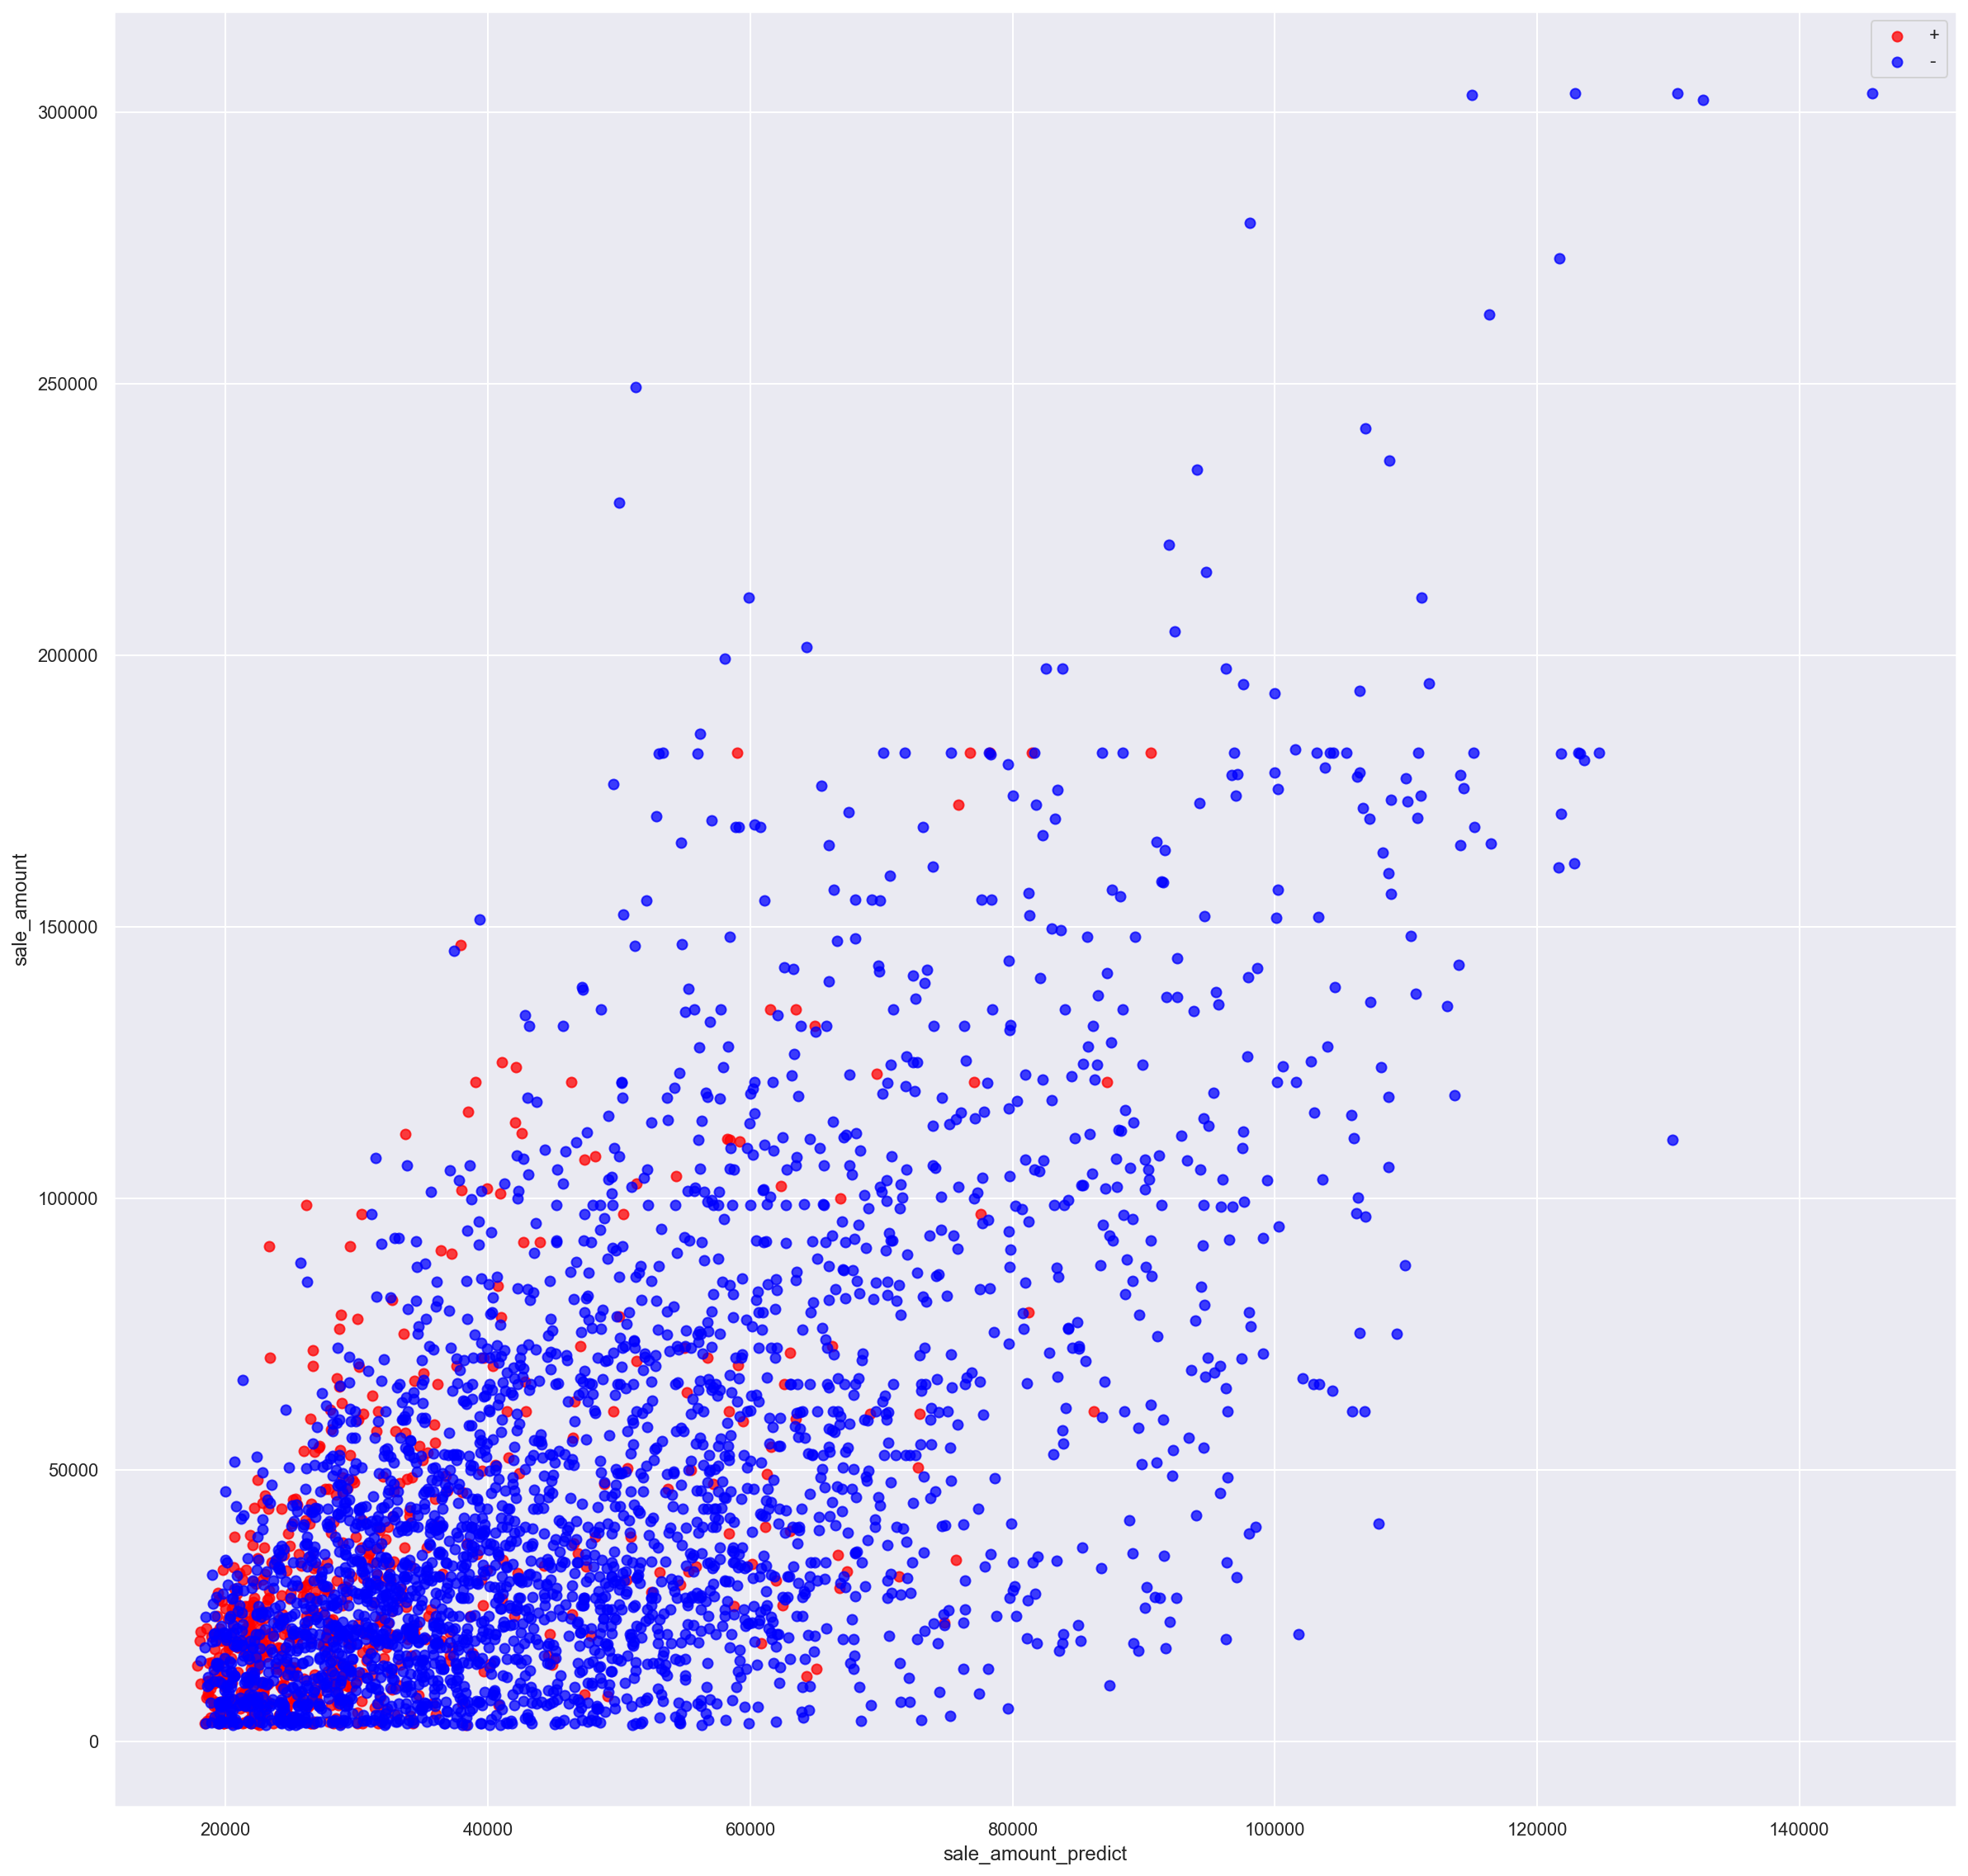

In [21]:
col1 = 'sale_amount_predict'
col2 = 'sale_amount'

plt.figure(figsize=(20, 20))

plt.scatter(df[col1][df['target'] == 0],
            df[col2][df['target'] == 0],
            alpha=0.75,
            color='red',
            label='+')

plt.scatter(df[col1][df['target'] == 1],
            df[col2][df['target'] == 1],
            alpha=0.75,
            color='blue',
            label='-')

plt.xlabel(col1)
plt.ylabel(col2)
plt.legend(loc='best');